In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
import glob

train_images = sorted(glob.glob("/content/drive/MyDrive/Final/Split/Images/Train/*.jpg"))
train_masks  = sorted(glob.glob("/content/drive/MyDrive/Final/Split/Labels/Train/*.jpg"))
val_images   = sorted(glob.glob("/content/drive/MyDrive/Final/Split/Images/Val/*.jpg"))
val_masks    = sorted(glob.glob("/content/drive/MyDrive/Final/Split/Labels/Val/*.jpg"))
test_images  = sorted(glob.glob("/content/drive/MyDrive/Final/Split/Images/Test/*.jpg"))
test_masks   = sorted(glob.glob("/content/drive/MyDrive/Final/Split/Labels/Test/*.jpg"))

print("Jumlah data training:", len(train_images))
print("Jumlah data testing:", len(test_images))
print("Jumlah data validasi:", len(val_images))

Jumlah data training: 1183
Jumlah data testing: 338
Jumlah data validasi: 169


In [55]:
class TumorSegmentationGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=4, target_size=(512, 512), shuffle=True): # Changed _init_ to __init__
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))  # Hindari batch tidak penuh

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

        images = []
        masks = []

        for idx in indexes:
            image = cv2.imread(self.image_paths[idx])
            image = cv2.resize(image, self.target_size)
            image = image.astype(np.float32) / 255.0

            mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, self.target_size)
            mask = (mask > 127).astype(np.float32)
            mask = np.expand_dims(mask, axis=-1)

            images.append(image)
            masks.append(mask)

        return np.array(images, dtype=np.float32), np.array(masks, dtype=np.float32)

In [48]:
def build_segmentation_model(input_shape=(512, 512, 3)):
    inputs = layers.Input(shape=input_shape)

    # Downsampling (encoder)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)  # 256x256
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)  # 128x128
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)  # 64x64

    # Bottleneck
    x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)

    # Upsampling (decoder) - jangan over!
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same')(x)  # 128x128
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same')(x)   # 256x256
    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same')(x)   # 512x512

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)

    return models.Model(inputs, outputs)

In [49]:
import tensorflow as tf
from tensorflow.keras import layers, models

def conv_block(x, filters, kernel_size=3):
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def build_mask_rcnn(input_shape=(512, 512, 3), num_classes=1):
    inputs = layers.Input(shape=input_shape)

    # Backbone: ResNet50 pretrained
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
    C3 = base_model.get_layer("conv3_block4_out").output  # 64x64
    C4 = base_model.get_layer("conv4_block6_out").output  # 32x32
    C5 = base_model.get_layer("conv5_block3_out").output  # 16x16

    # Feature Pyramid Network (FPN)
    P5 = conv_block(C5, 256)                             # 16x16
    P4 = layers.Add()([conv_block(C4, 256), layers.UpSampling2D()(P5)])  # 32x32
    P3 = layers.Add()([conv_block(C3, 256), layers.UpSampling2D()(P4)])  # 64x64

    # Dummy RPN + ROI Pooling (simplified)
    roi_pooled = layers.GlobalAveragePooling2D()(P3)
    bbox_output = layers.Dense(4, name='bbox_deltas')(roi_pooled)

    # Mask branch decoder - target output 512x512
    x = conv_block(P3, 256)                    # 64x64
    x = layers.UpSampling2D(size=(2,2))(x)     # 128x128
    x = conv_block(x, 128)
    x = layers.UpSampling2D(size=(2,2))(x)     # 256x256
    x = conv_block(x, 64)
    x = layers.UpSampling2D(size=(2,2))(x)     # 512x512
    x = conv_block(x, 32)

    mask_output = layers.Conv2D(num_classes, (1,1), activation='sigmoid', name='mask_output')(x)

    # Final model
    return models.Model(inputs, outputs=mask_output)

In [50]:
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

model = build_mask_rcnn()

model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy'])

In [51]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss", mode="min")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)

In [56]:
train_gen = TumorSegmentationGenerator(train_images, train_masks, batch_size=4)
val_gen = TumorSegmentationGenerator(val_images, val_masks, batch_size=4)

In [57]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=[checkpoint, reduce_lr, early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8727 - loss: 0.4874

295/295 ━━━━━━━━━━━━━━━━━━━━ 611s 2s/step - accuracy: 0.8728 - loss: 0.4872 - val_accuracy: 0.8826 - val_loss: 0.9912 - learning_rate: 0.0010
Epoch 2/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 108s 364ms/step - accuracy: 0.9153 - loss: 0.3669 - val_accuracy: 0.8823 - val_loss: 0.9996 - learning_rate: 0.0010
Epoch 3/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 141s 363ms/step - accuracy: 0.9190 - loss: 0.3446 - val_accuracy: 0.8839 - val_loss: 0.9998 - learning_rate: 0.0010
Epoch 4/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.9302 - loss: 0.3029

295/295 ━━━━━━━━━━━━━━━━━━━━ 108s 365ms/step - accuracy: 0.9302 - loss: 0.3029 - val_accuracy: 0.8848 - val_loss: 0.9415 - learning_rate: 0.0010
Epoch 5/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.9312 - loss: 0.2997

295/295 ━━━━━━━━━━━━━━━━━━━━ 106s 359ms/step - accuracy: 0.9312 - loss: 0.2996 - val_accuracy: 0.9271 - val_loss: 0.2972 - learning_rate: 0.0010
Epoch 6/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 106s 360ms/step - accuracy: 0.9443 - loss: 0.2493 - val_accuracy: 0.9163 - val_loss: 0.4209 - learning_rate: 0.0010
Epoch 7/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 146s 375ms/step - accuracy: 0.9474 - loss: 0.2319 - val_accuracy: 0.9203 - val_loss: 0.4817 - learning_rate: 0.0010
Epoch 8/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.9514 - loss: 0.2201

295/295 ━━━━━━━━━━━━━━━━━━━━ 116s 394ms/step - accuracy: 0.9514 - loss: 0.2200 - val_accuracy: 0.9287 - val_loss: 0.2897 - learning_rate: 0.0010
Epoch 9/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.9579 - loss: 0.1935

295/295 ━━━━━━━━━━━━━━━━━━━━ 117s 396ms/step - accuracy: 0.9579 - loss: 0.1935 - val_accuracy: 0.9525 - val_loss: 0.2154 - learning_rate: 0.0010
Epoch 10/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 135s 372ms/step - accuracy: 0.9617 - loss: 0.1729 - val_accuracy: 0.9476 - val_loss: 0.2461 - learning_rate: 0.0010
Epoch 11/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 142s 371ms/step - accuracy: 0.9647 - loss: 0.1581 - val_accuracy: 0.9172 - val_loss: 0.4603 - learning_rate: 0.0010
Epoch 12/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.9663 - loss: 0.1536

295/295 ━━━━━━━━━━━━━━━━━━━━ 116s 392ms/step - accuracy: 0.9663 - loss: 0.1535 - val_accuracy: 0.9568 - val_loss: 0.1739 - learning_rate: 0.0010
Epoch 13/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 109s 371ms/step - accuracy: 0.9724 - loss: 0.1317 - val_accuracy: 0.9576 - val_loss: 0.2041 - learning_rate: 0.0010
Epoch 14/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 106s 359ms/step - accuracy: 0.9767 - loss: 0.1078 - val_accuracy: 0.9526 - val_loss: 0.2186 - learning_rate: 0.0010
Epoch 15/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.9788 - loss: 0.0967
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
295/295 ━━━━━━━━━━━━━━━━━━━━ 110s 372ms/step - accuracy: 0.9788 - loss: 0.0967 - val_accuracy: 0.9198 - val_loss: 0.5176 - learning_rate: 0.0010
Epoch 16/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.9836 - loss: 0.0756

295/295 ━━━━━━━━━━━━━━━━━━━━ 111s 378ms/step - accuracy: 0.9836 - loss: 0.0756 - val_accuracy: 0.9789 - val_loss: 0.0906 - learning_rate: 5.0000e-04
Epoch 17/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.9879 - loss: 0.0563

295/295 ━━━━━━━━━━━━━━━━━━━━ 114s 385ms/step - accuracy: 0.9879 - loss: 0.0563 - val_accuracy: 0.9825 - val_loss: 0.0776 - learning_rate: 5.0000e-04
Epoch 18/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.9892 - loss: 0.0523

295/295 ━━━━━━━━━━━━━━━━━━━━ 107s 361ms/step - accuracy: 0.9892 - loss: 0.0523 - val_accuracy: 0.9842 - val_loss: 0.0738 - learning_rate: 5.0000e-04
Epoch 19/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.9909 - loss: 0.0420

295/295 ━━━━━━━━━━━━━━━━━━━━ 146s 373ms/step - accuracy: 0.9909 - loss: 0.0420 - val_accuracy: 0.9861 - val_loss: 0.0595 - learning_rate: 5.0000e-04
Epoch 20/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 104s 353ms/step - accuracy: 0.9923 - loss: 0.0359 - val_accuracy: 0.9753 - val_loss: 0.1155 - learning_rate: 5.0000e-04
Epoch 21/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.9918 - loss: 0.0391

295/295 ━━━━━━━━━━━━━━━━━━━━ 110s 373ms/step - accuracy: 0.9918 - loss: 0.0391 - val_accuracy: 0.9881 - val_loss: 0.0538 - learning_rate: 5.0000e-04
Epoch 22/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.9935 - loss: 0.0294

295/295 ━━━━━━━━━━━━━━━━━━━━ 113s 384ms/step - accuracy: 0.9935 - loss: 0.0294 - val_accuracy: 0.9883 - val_loss: 0.0497 - learning_rate: 5.0000e-04
Epoch 23/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.9926 - loss: 0.0327

295/295 ━━━━━━━━━━━━━━━━━━━━ 107s 361ms/step - accuracy: 0.9926 - loss: 0.0326 - val_accuracy: 0.9892 - val_loss: 0.0468 - learning_rate: 5.0000e-04
Epoch 24/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 105s 355ms/step - accuracy: 0.9926 - loss: 0.0355 - val_accuracy: 0.9878 - val_loss: 0.0531 - learning_rate: 5.0000e-04
Epoch 25/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.9939 - loss: 0.0284

295/295 ━━━━━━━━━━━━━━━━━━━━ 108s 365ms/step - accuracy: 0.9939 - loss: 0.0283 - val_accuracy: 0.9906 - val_loss: 0.0384 - learning_rate: 5.0000e-04


In [62]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions_triplet_colored(model, test_gen, num_images=10):
    for i in range(min(num_images, len(test_gen))):
        image_batch, mask_batch = test_gen[i]
        image = image_batch[0]  # (512, 512, 3)

        # Handle y_true bisa berupa dict atau array
        if isinstance(mask_batch, dict):
            true_mask = mask_batch["mask_output"][0, :, :, 0]
        elif isinstance(mask_batch, list):
            true_mask = mask_batch[0][..., 0]
        else:
            true_mask = mask_batch[0, :, :, 0]

        # Predict
        prediction = model.predict(np.expand_dims(image, axis=0), verbose=0)

        # Ambil mask_output dari hasil prediksi
        if isinstance(prediction, dict):
            pred_mask = prediction["mask_output"][0, :, :, 0]
        elif isinstance(prediction, list):
            pred_mask = prediction[0][0, :, :, 0]
        else:
            pred_mask = prediction[0, :, :, 0]

        pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)

        # Overlay
        overlay = image.copy()
        overlay[pred_mask_bin == 1] = [255, 0, 0]

        # Plot 3 panel
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(image)
        axs[0].set_title("Raw Image")

        axs[1].imshow(true_mask, cmap='gray')
        axs[1].set_title("Ground Truth Mask")

        axs[2].imshow(overlay)
        axs[2].set_title("Predicted Mask (Overlay)")

        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

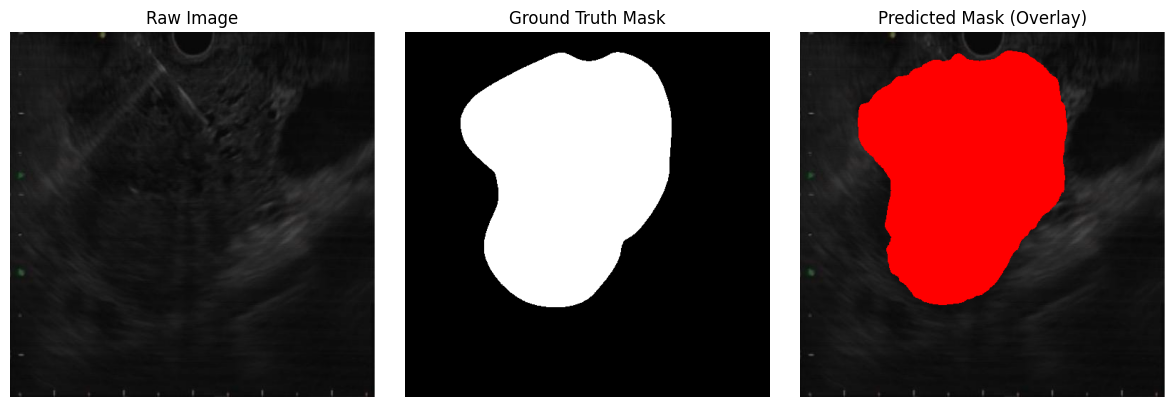

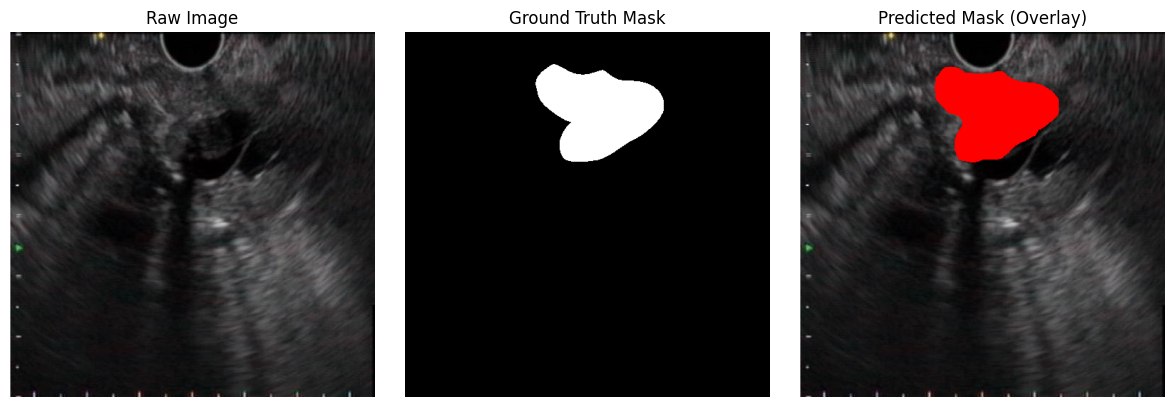

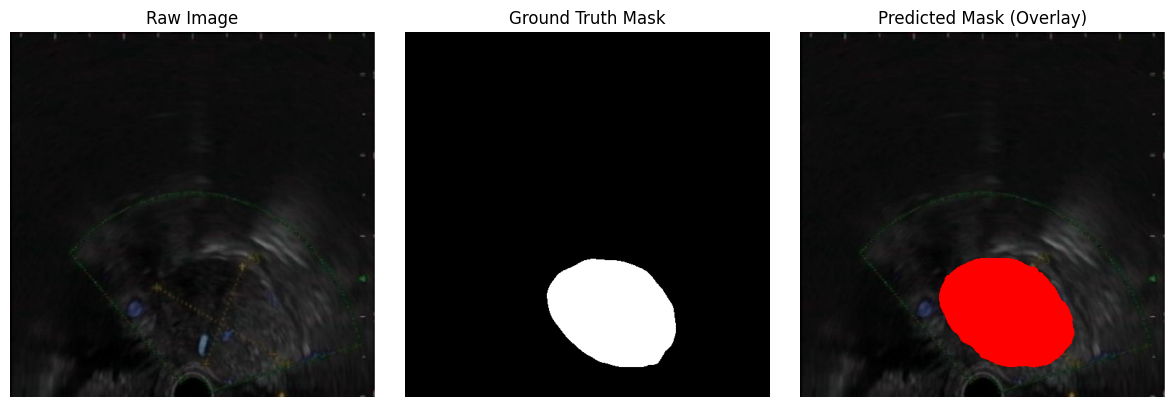

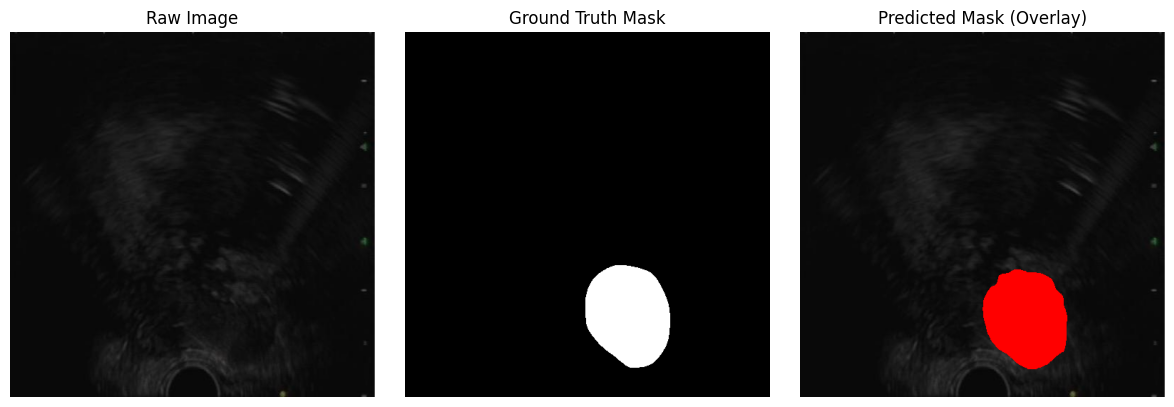

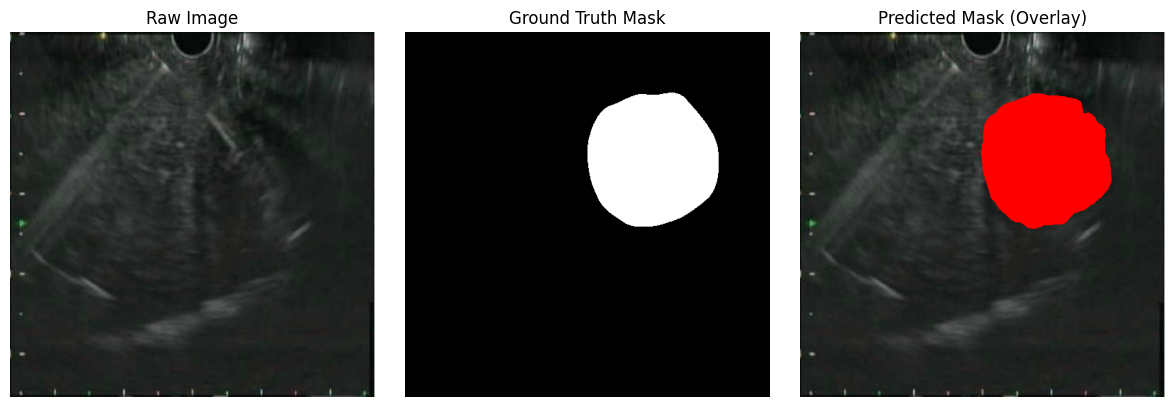

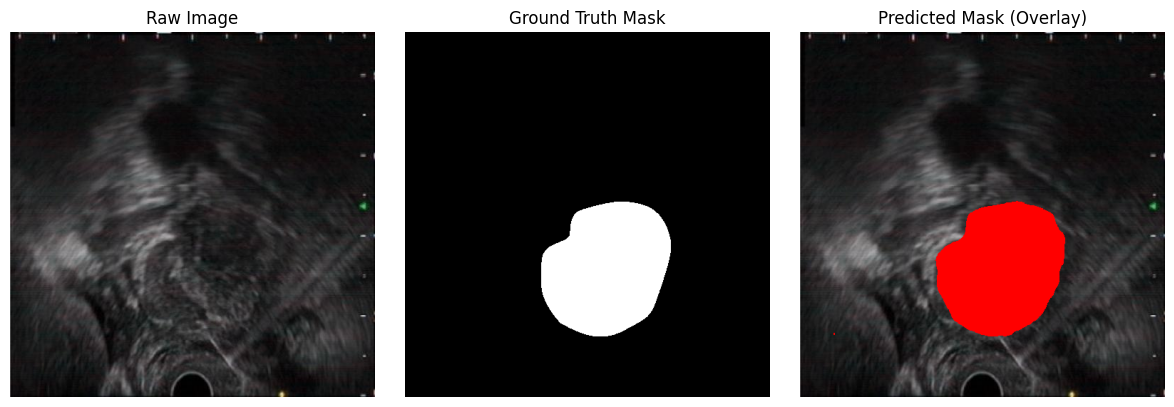

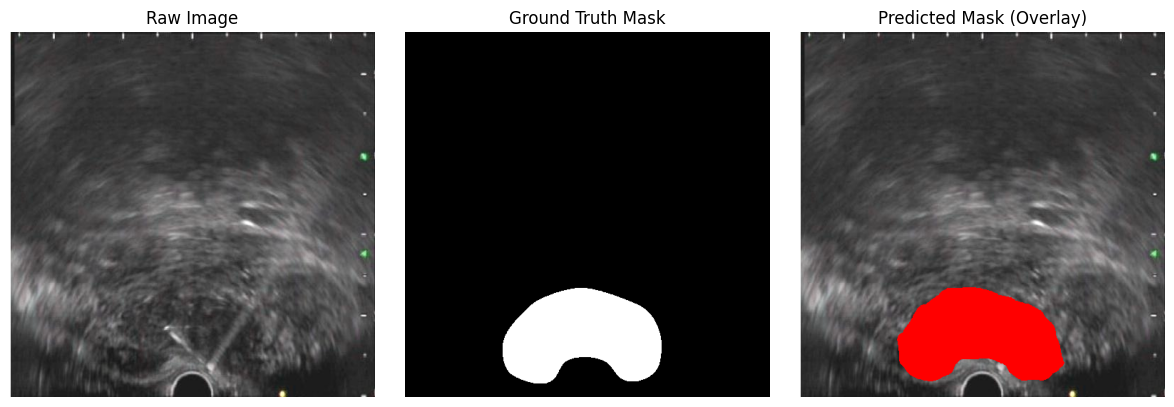

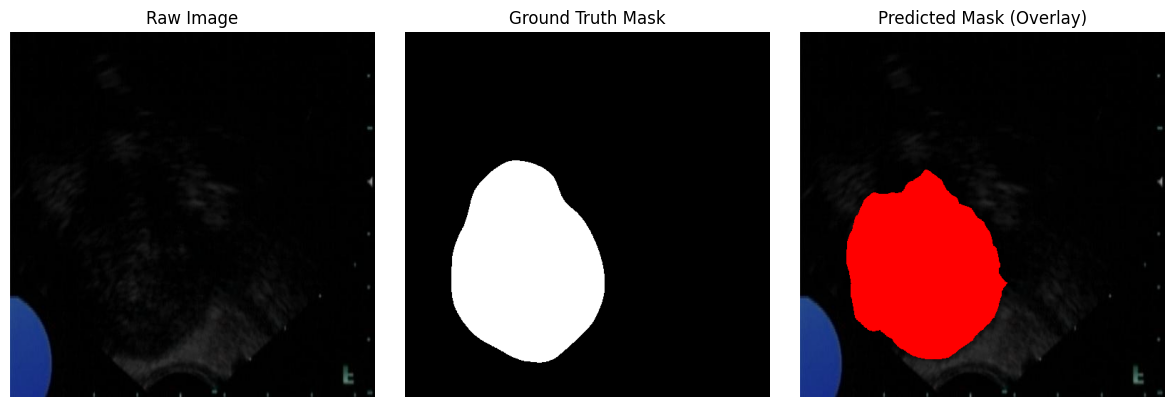

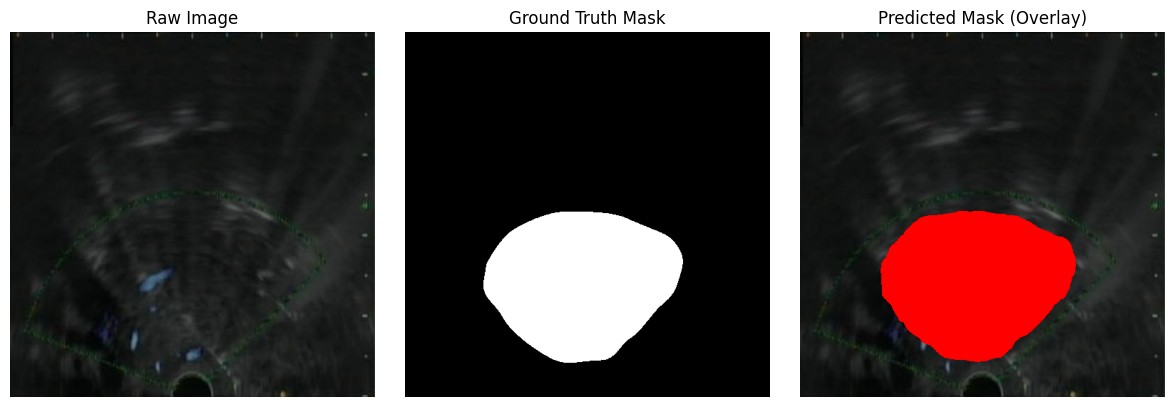

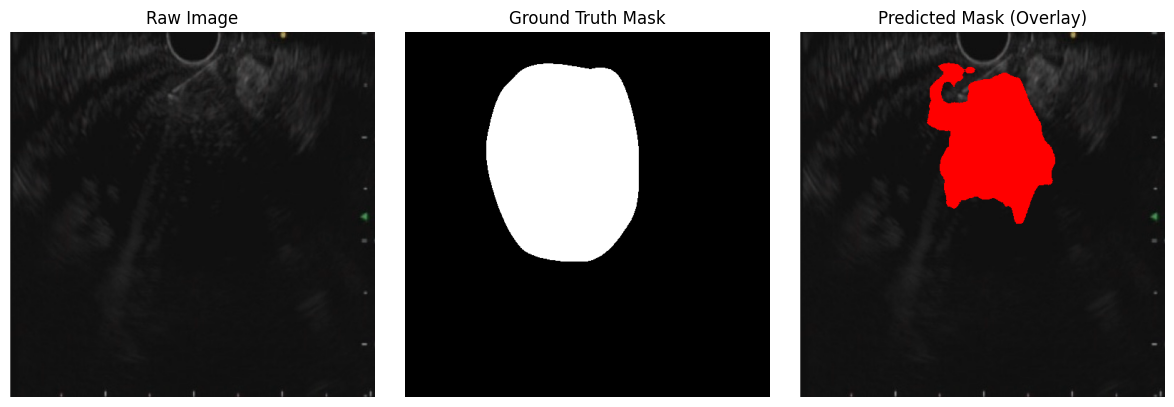

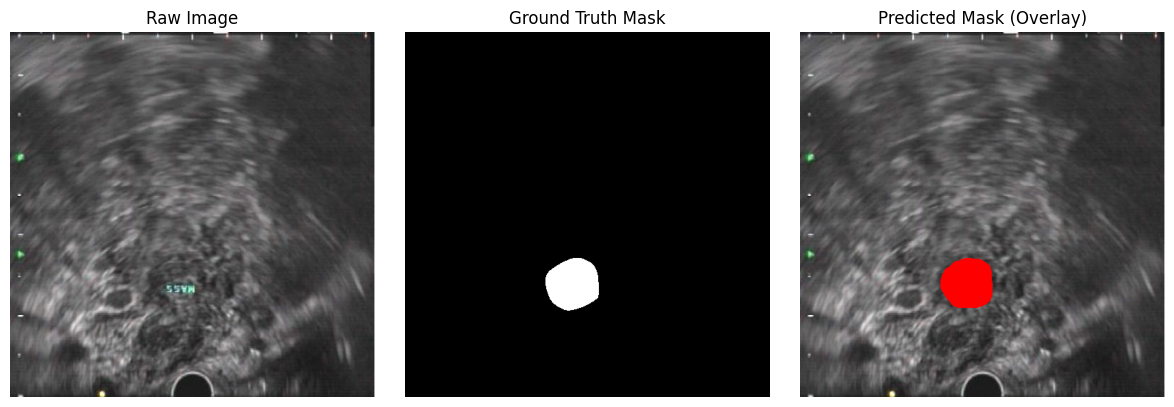

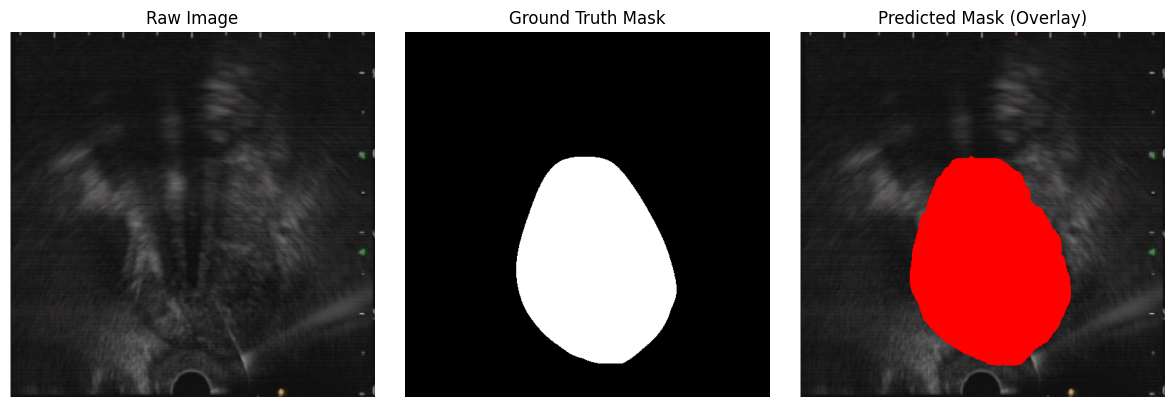

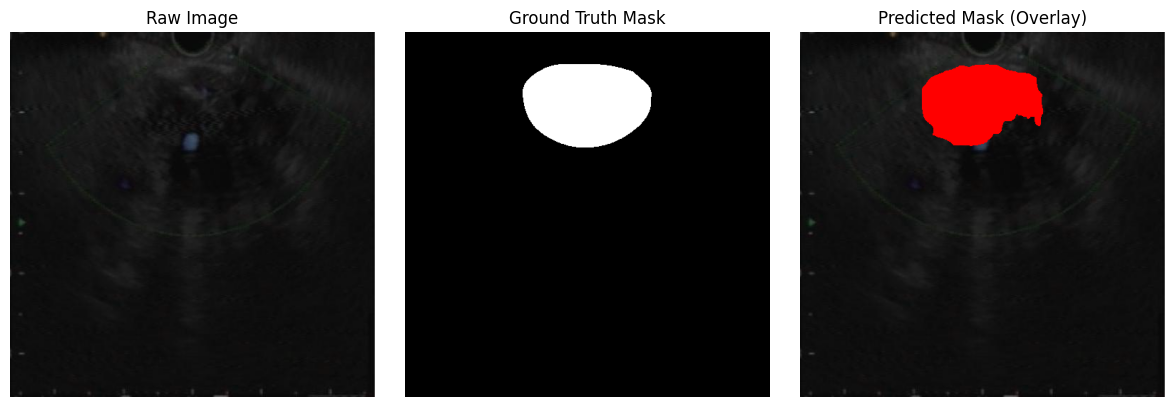

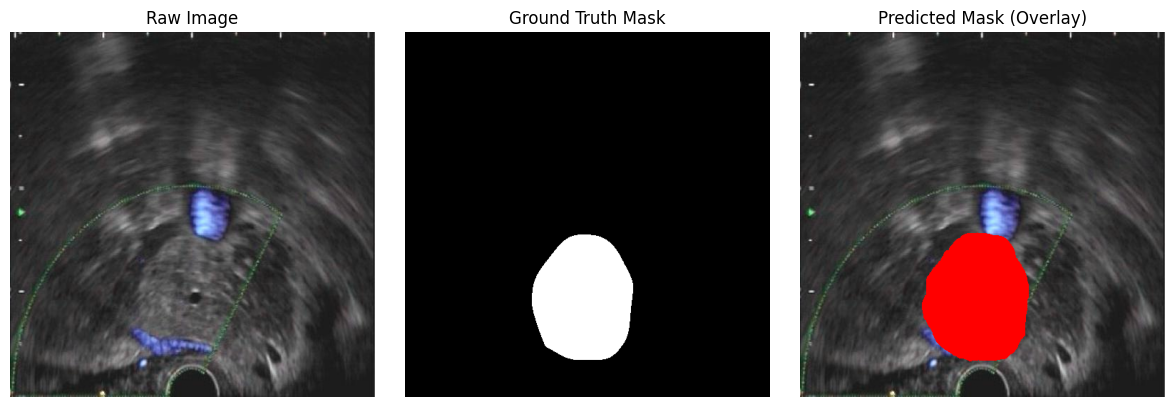

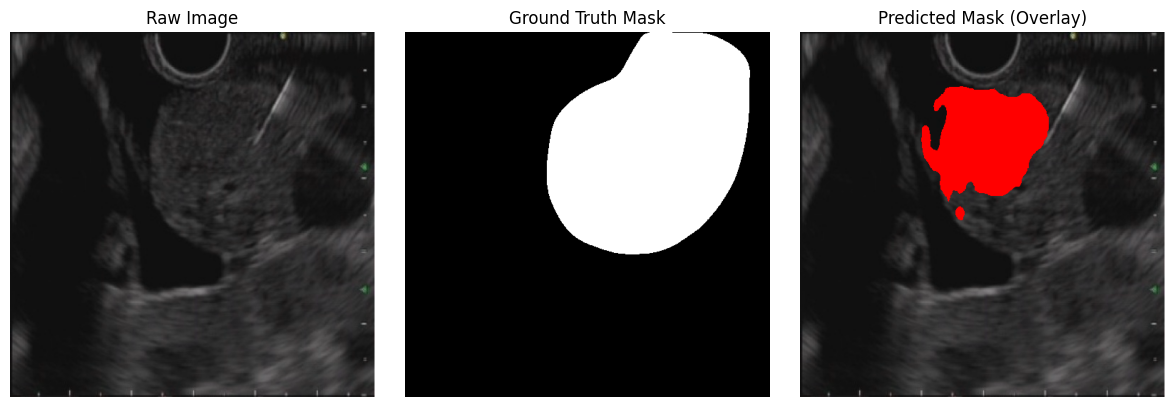

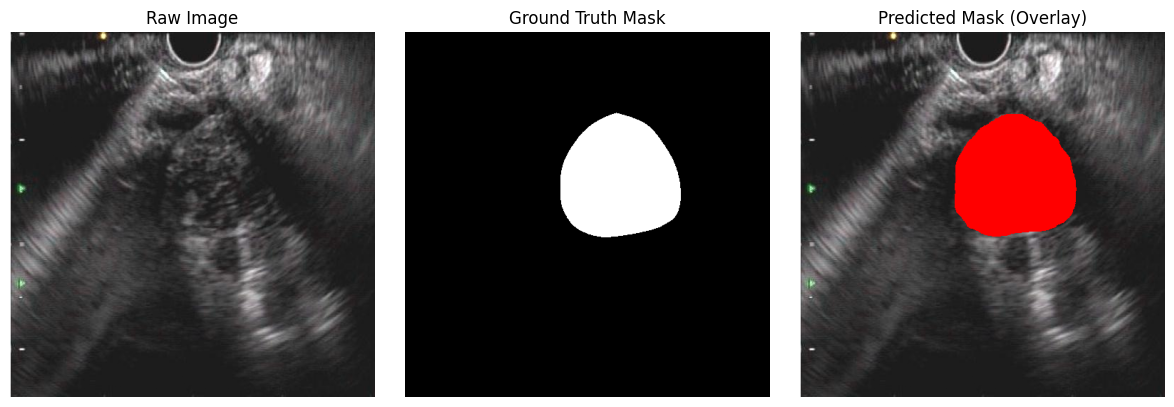

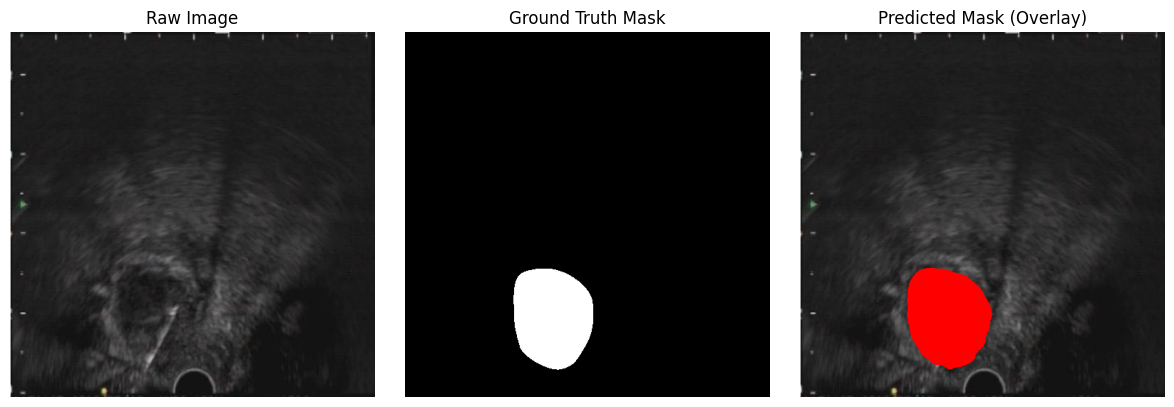

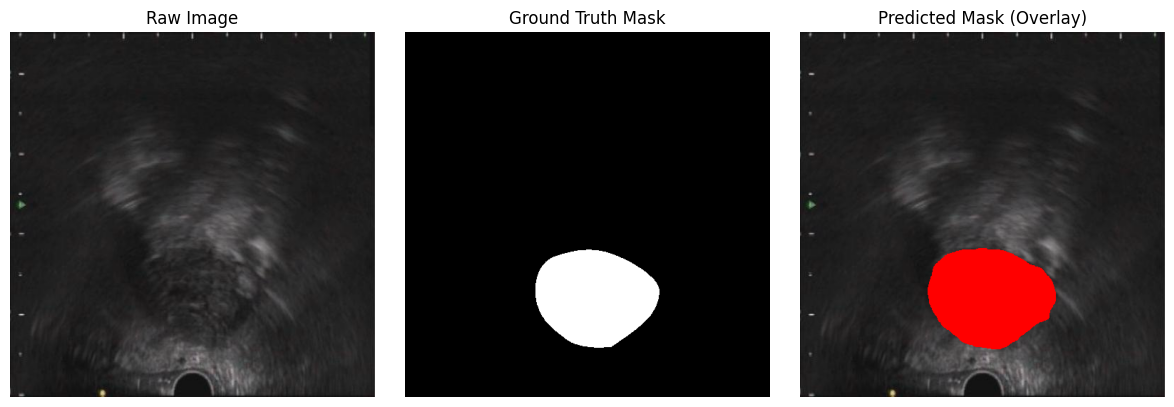

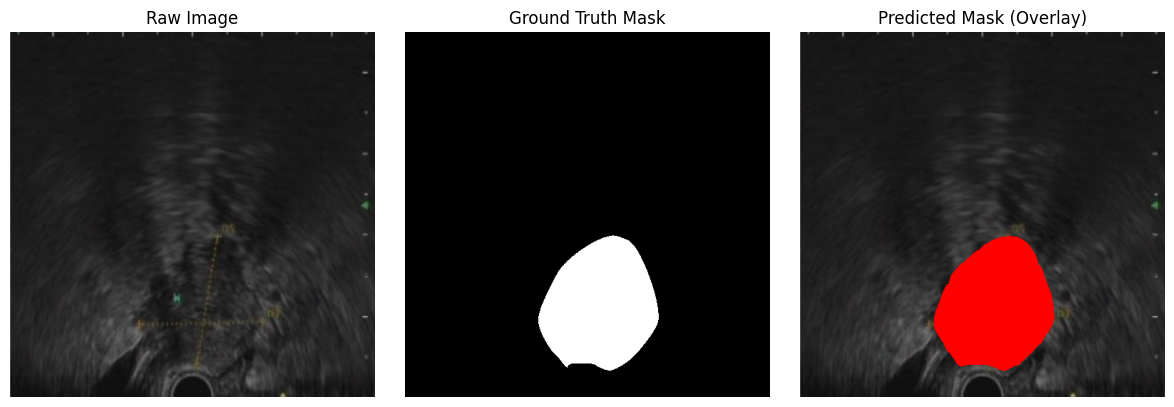

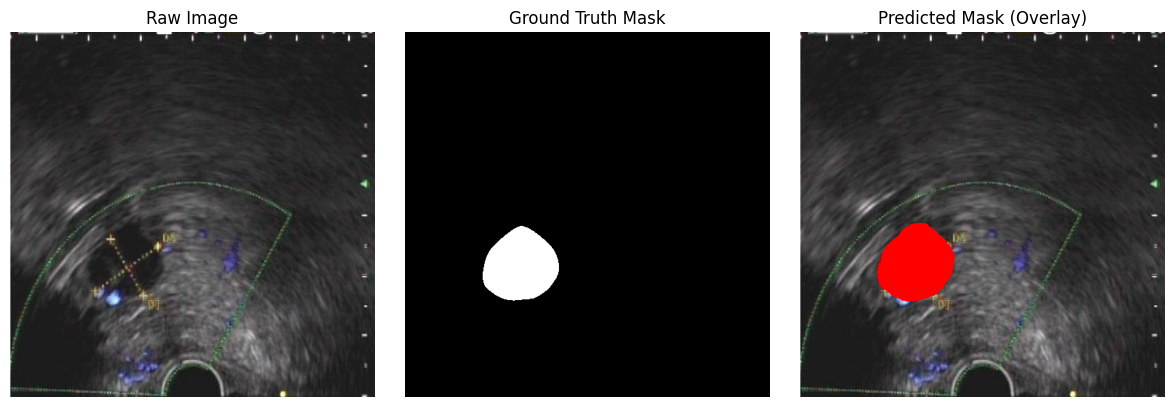

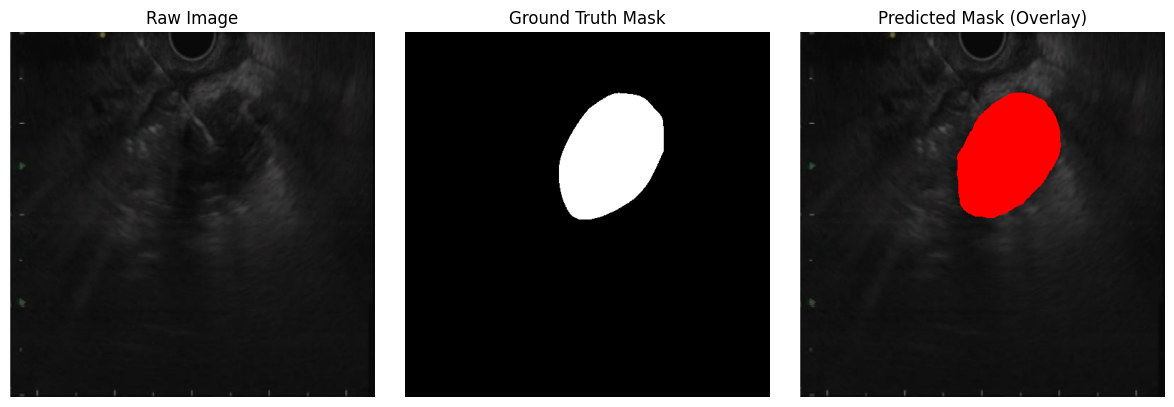

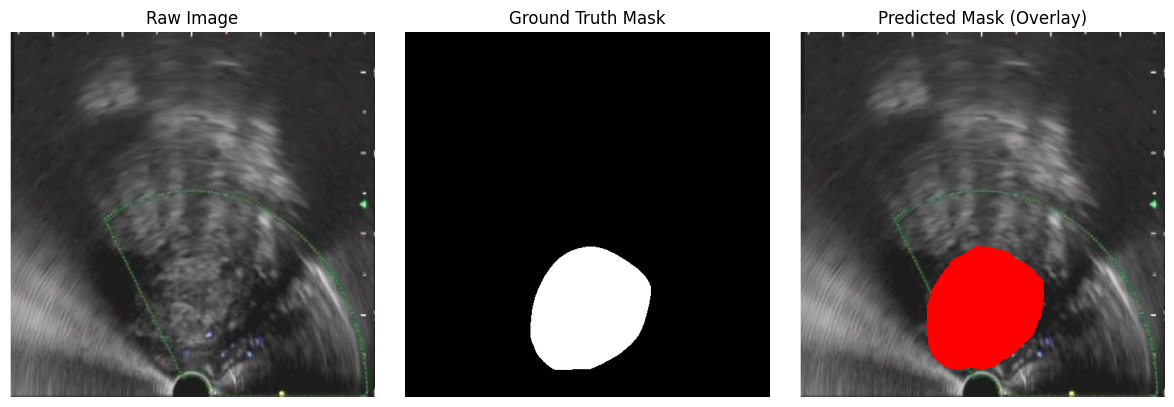

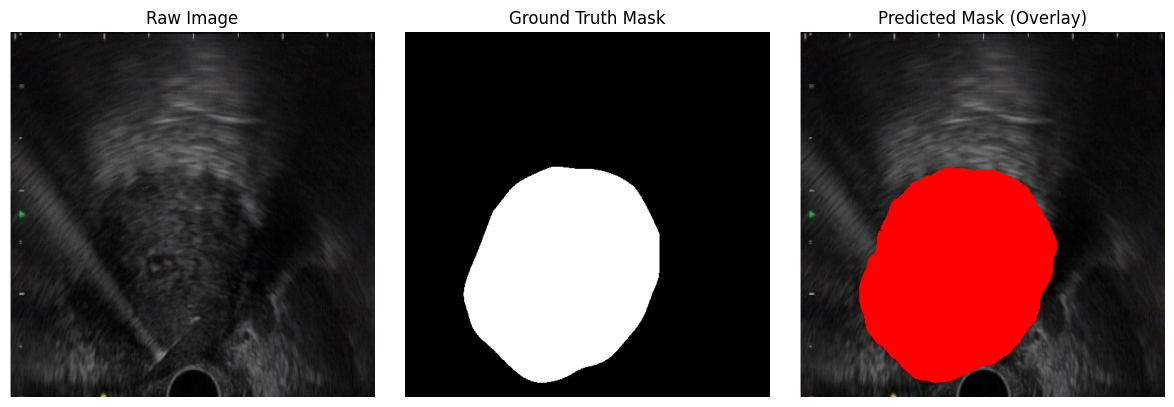

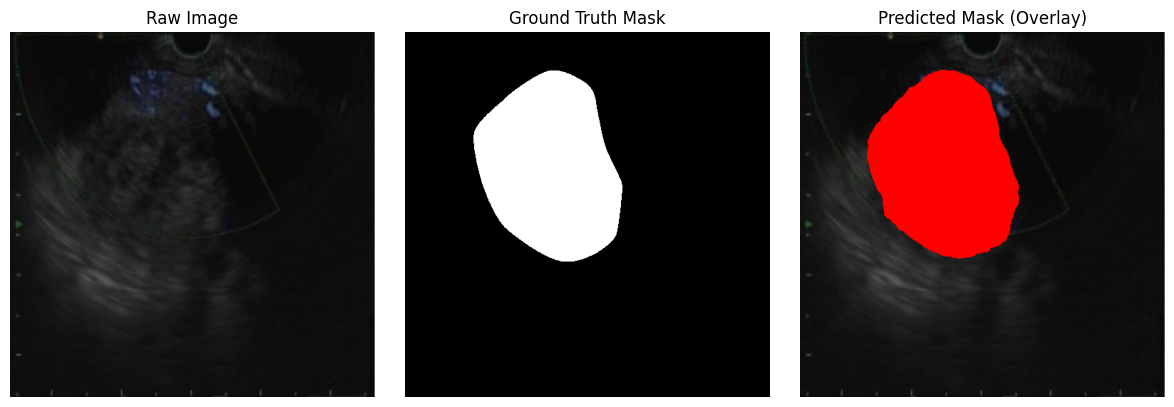

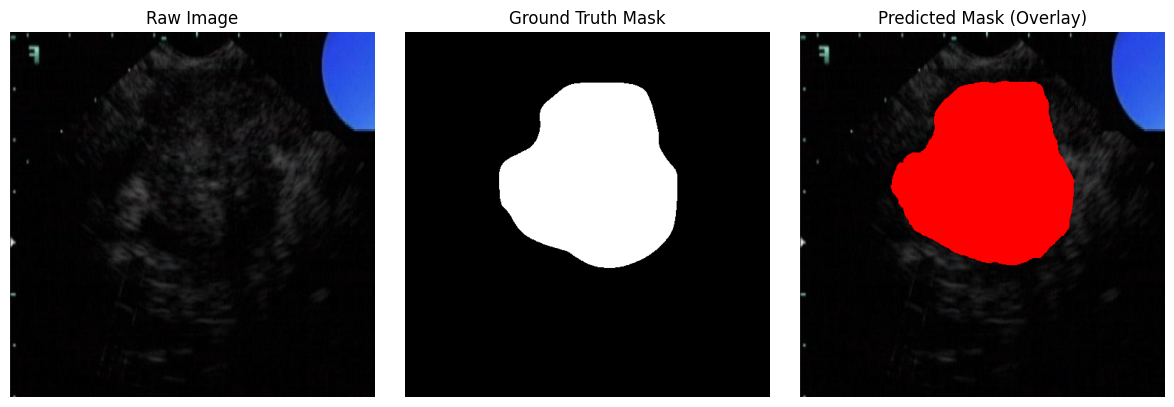

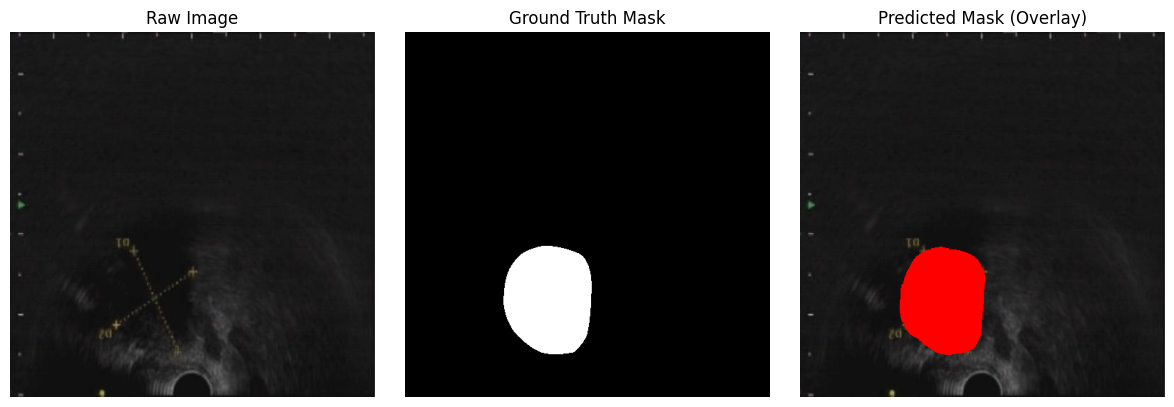

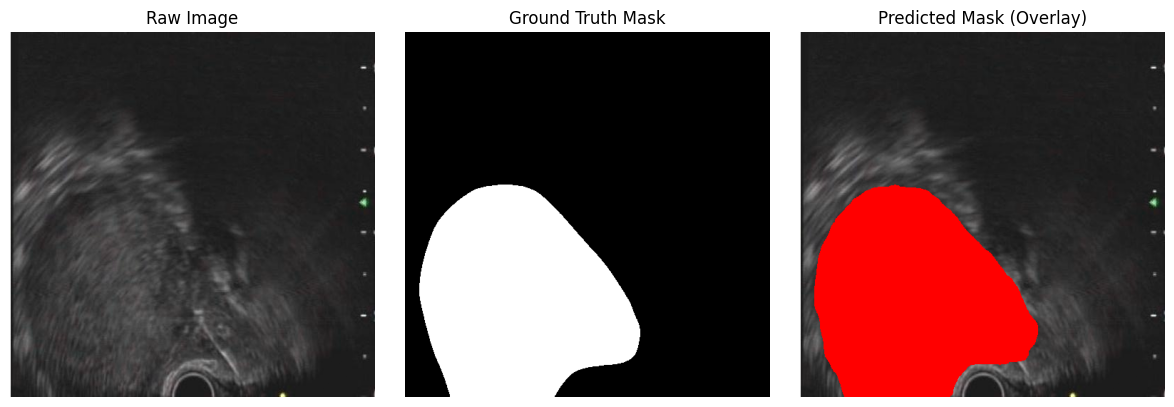

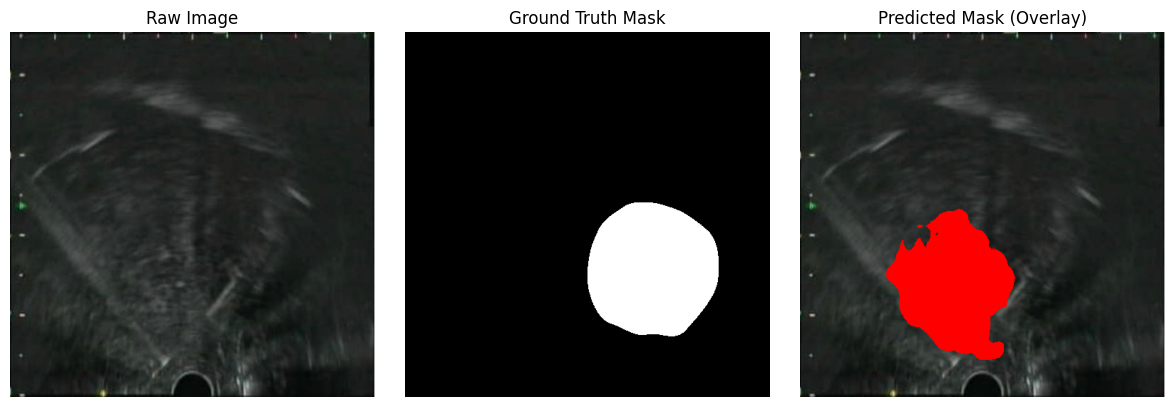

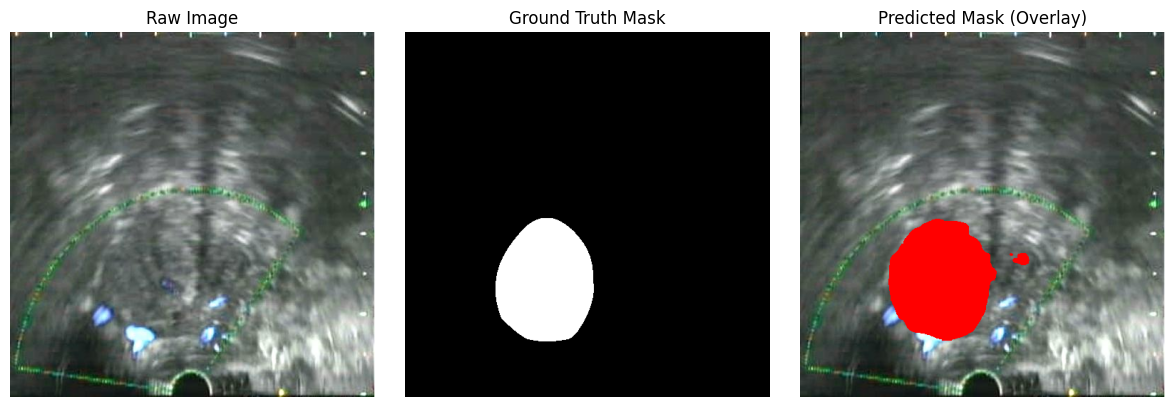

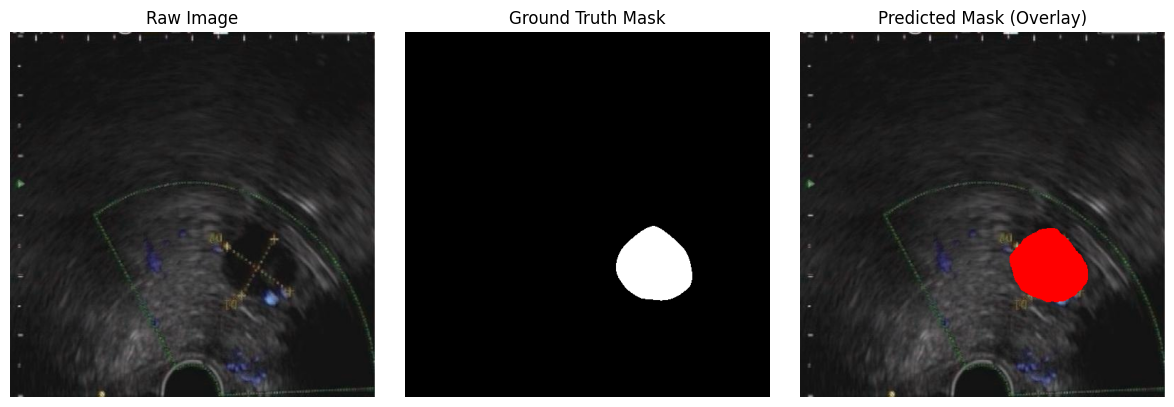

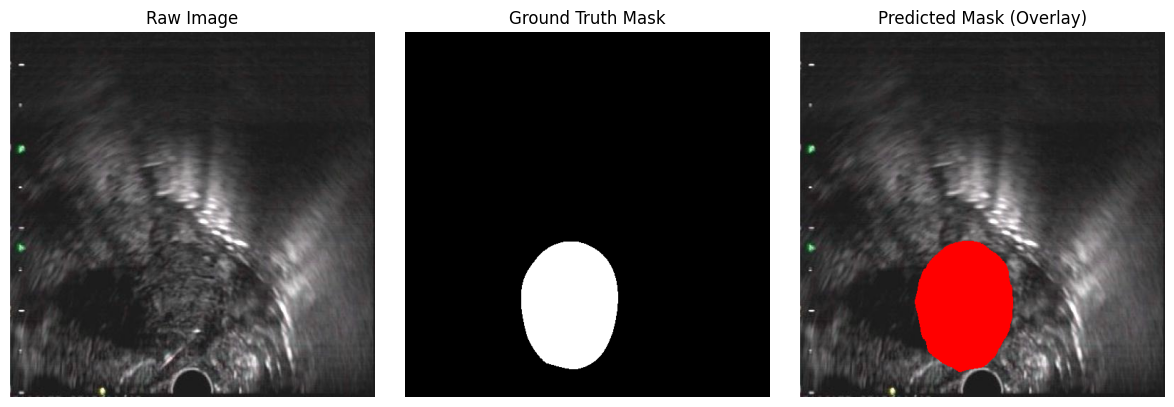

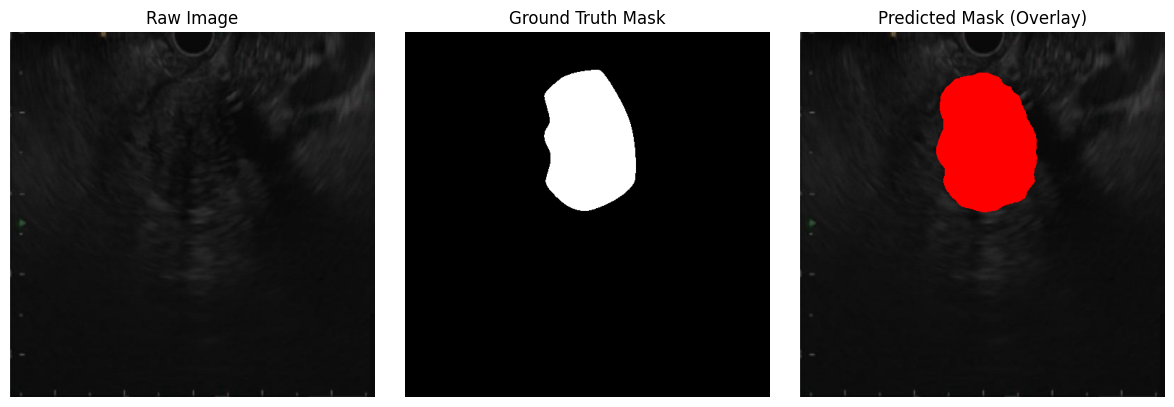

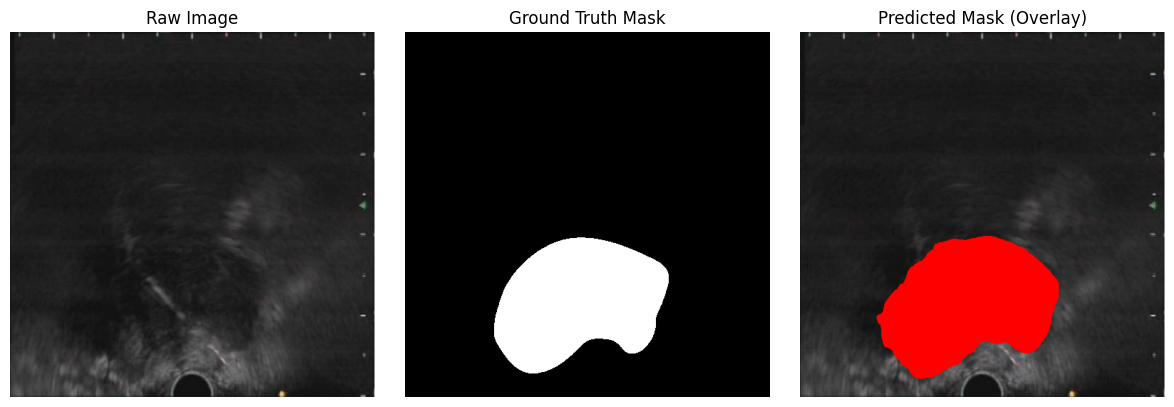

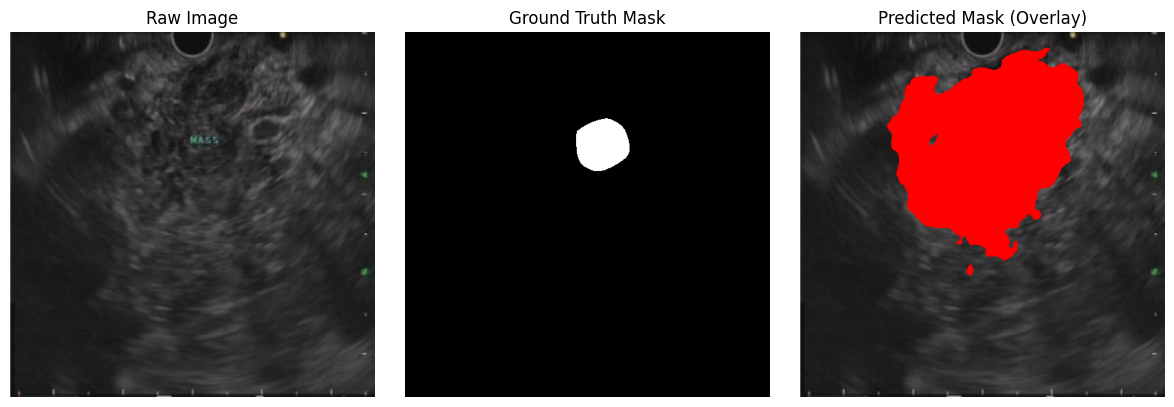

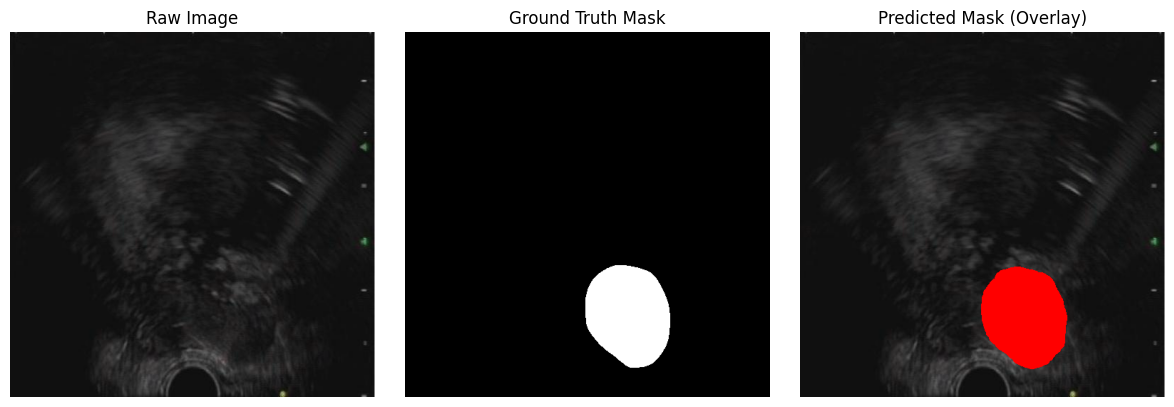

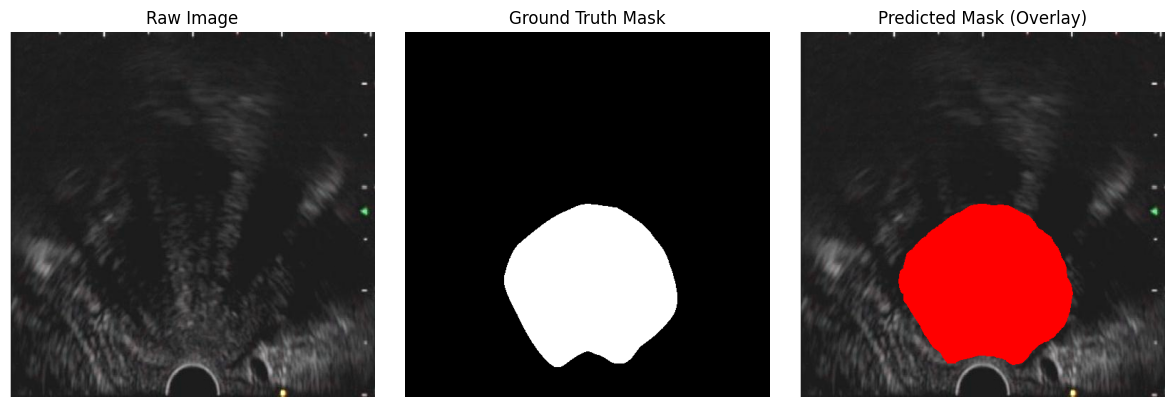

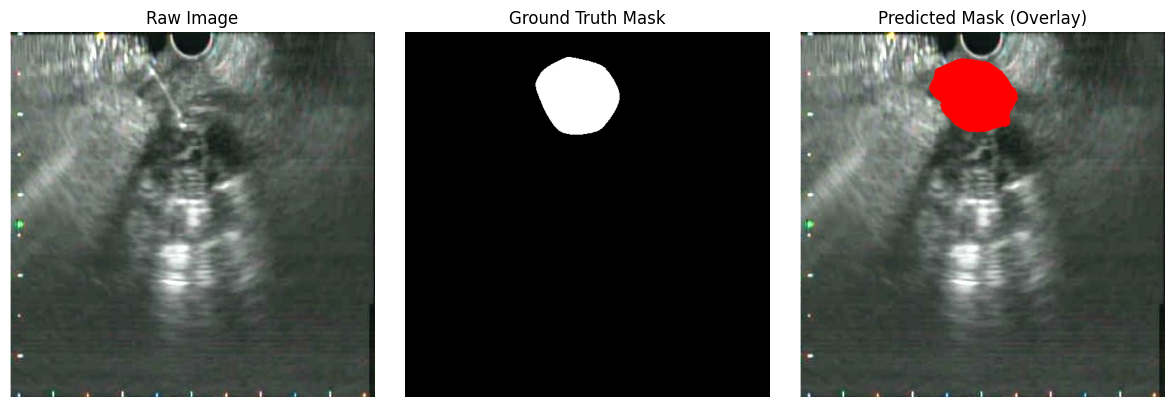

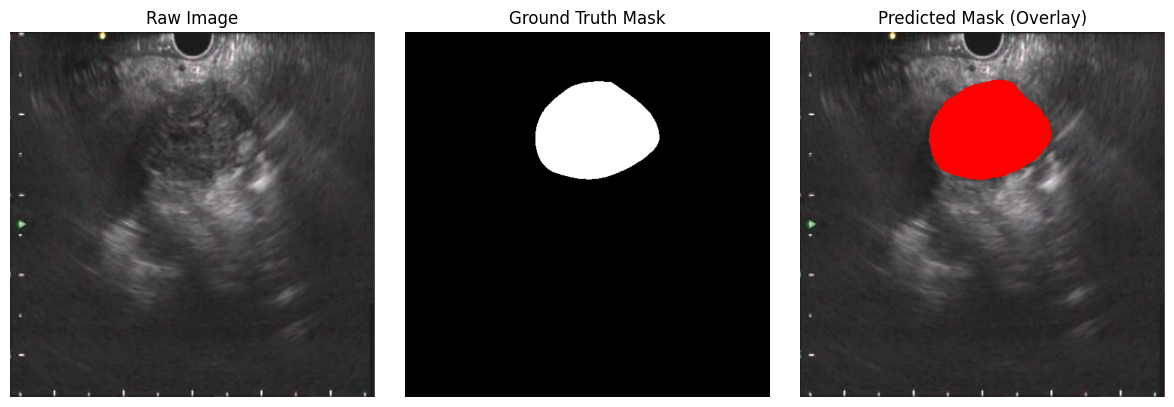

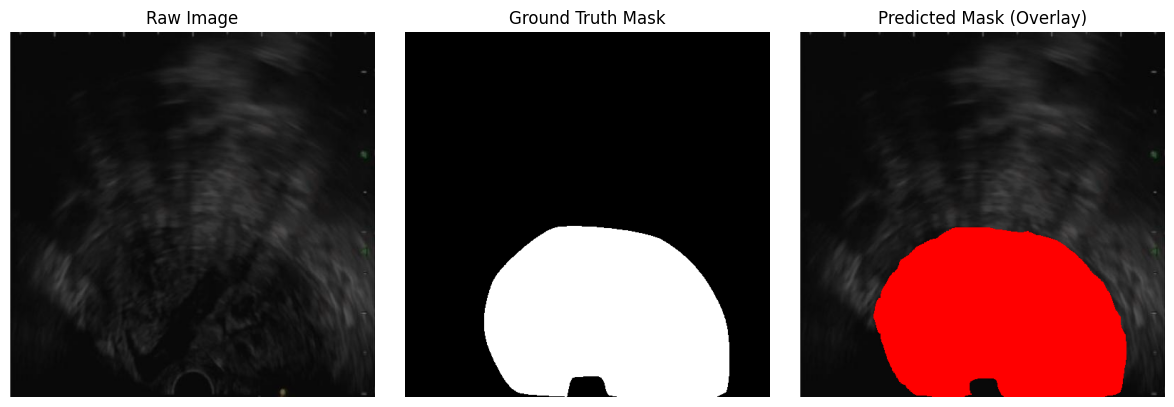

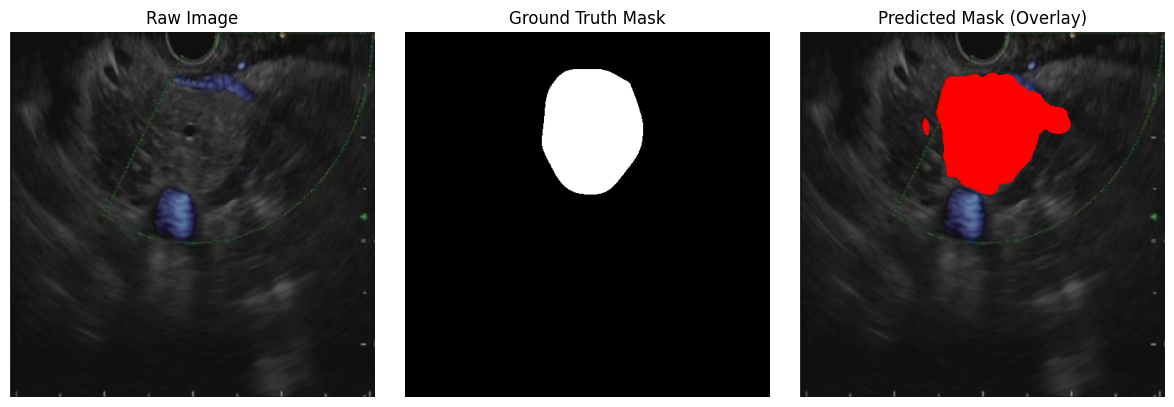

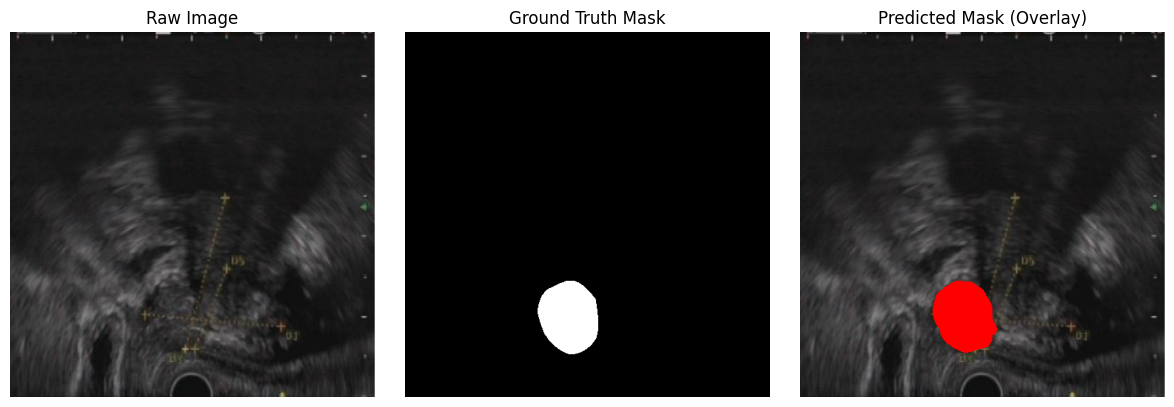

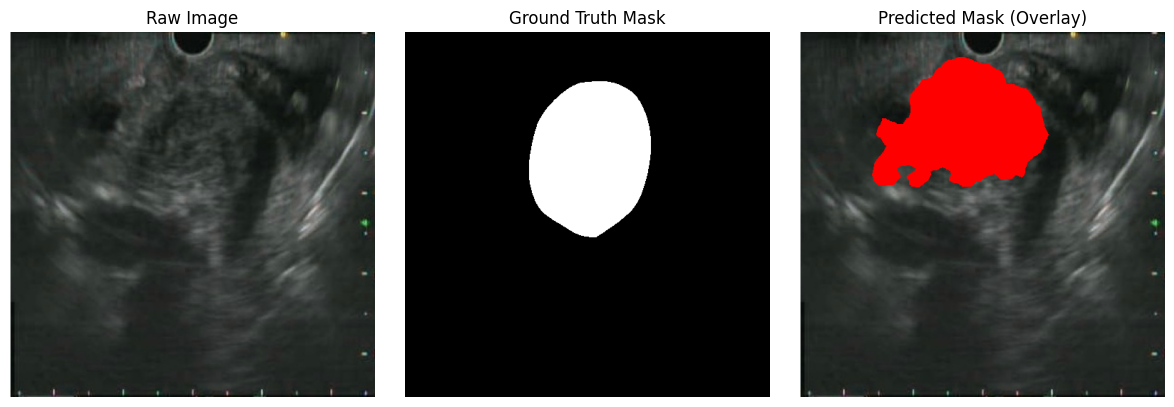

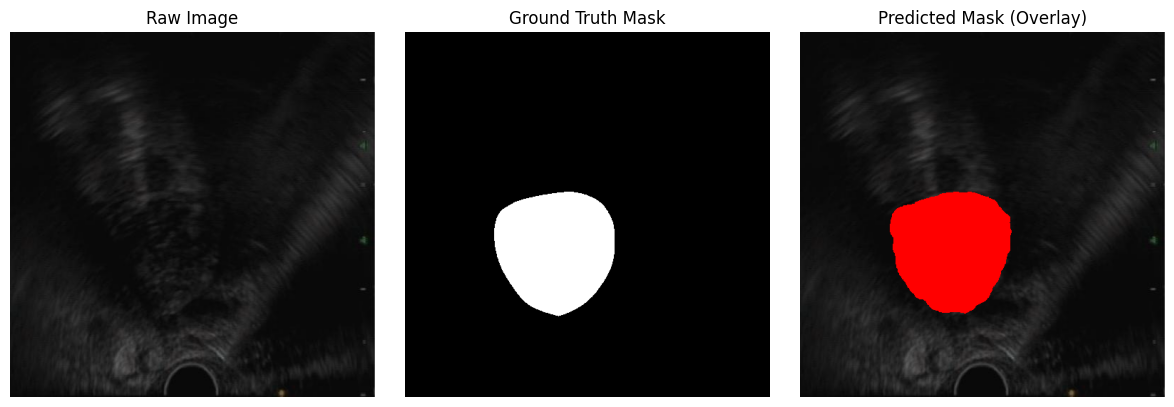

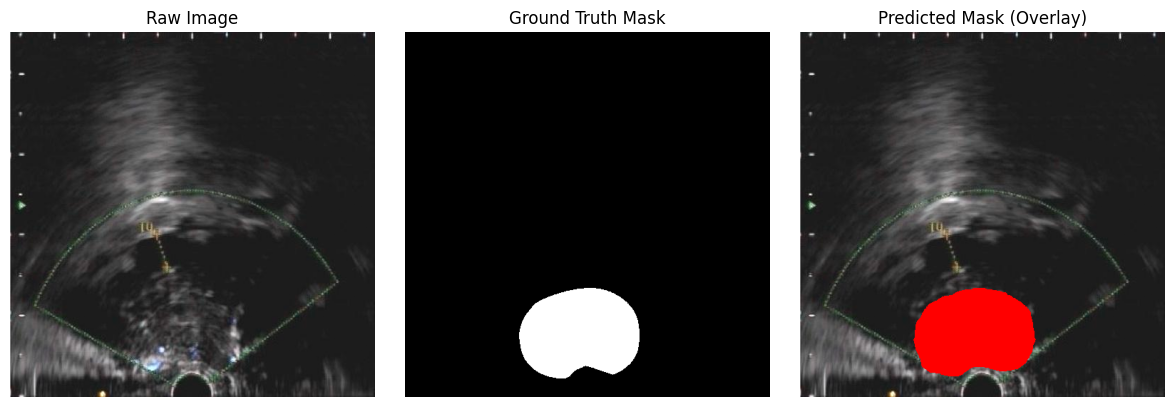

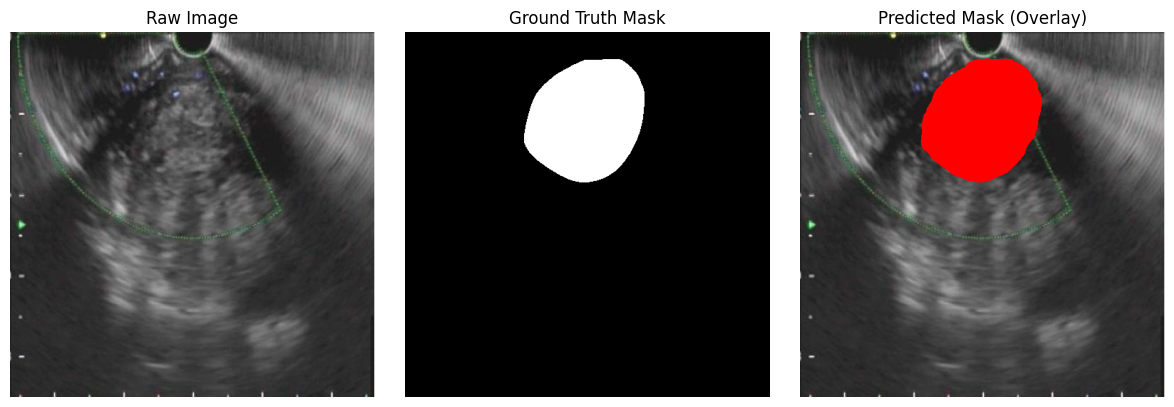

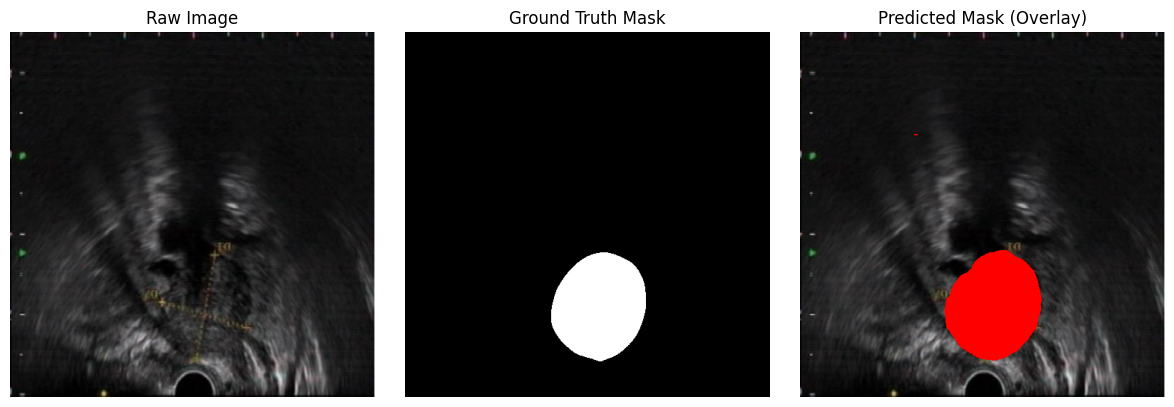

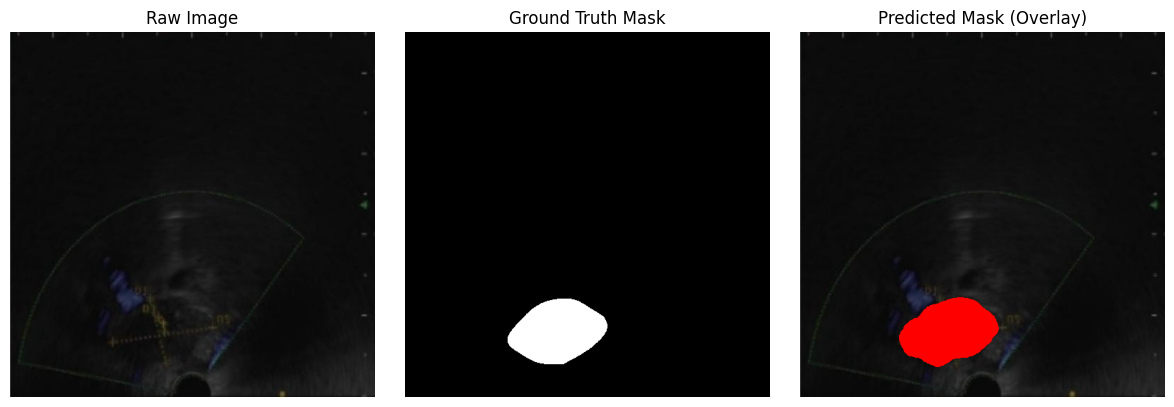

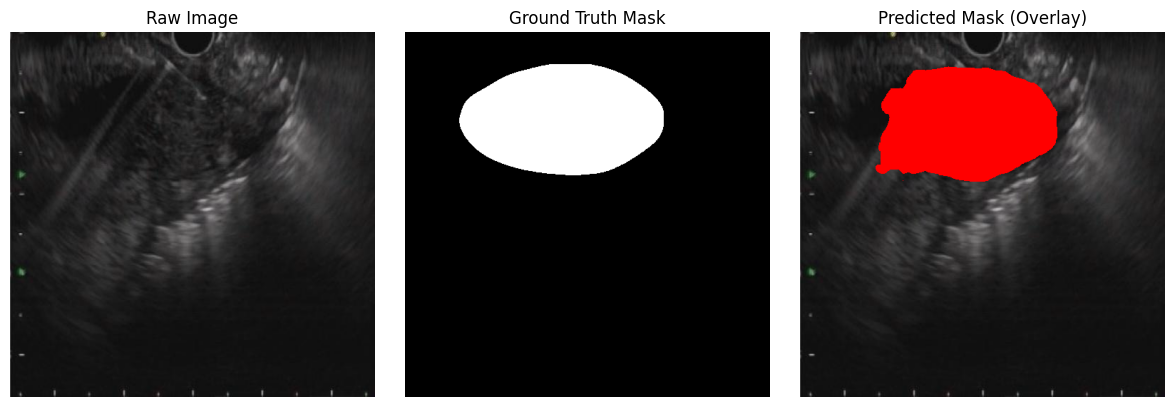

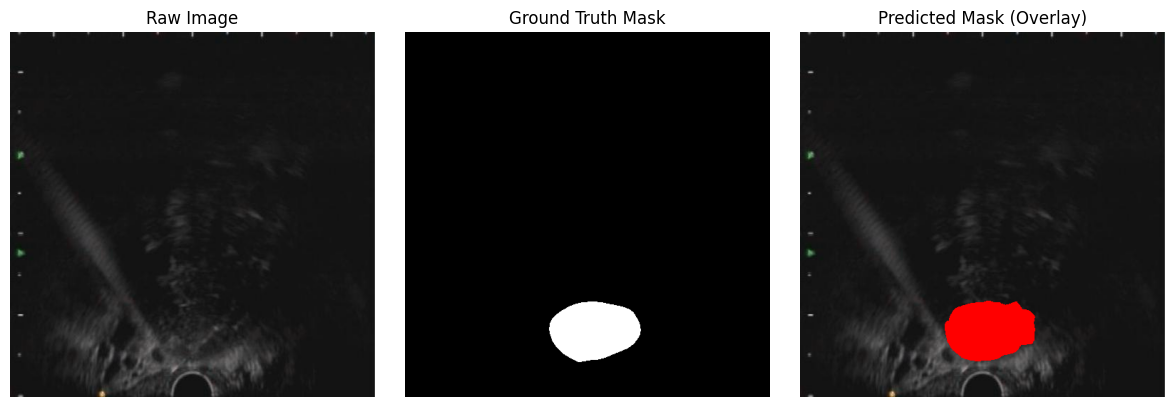

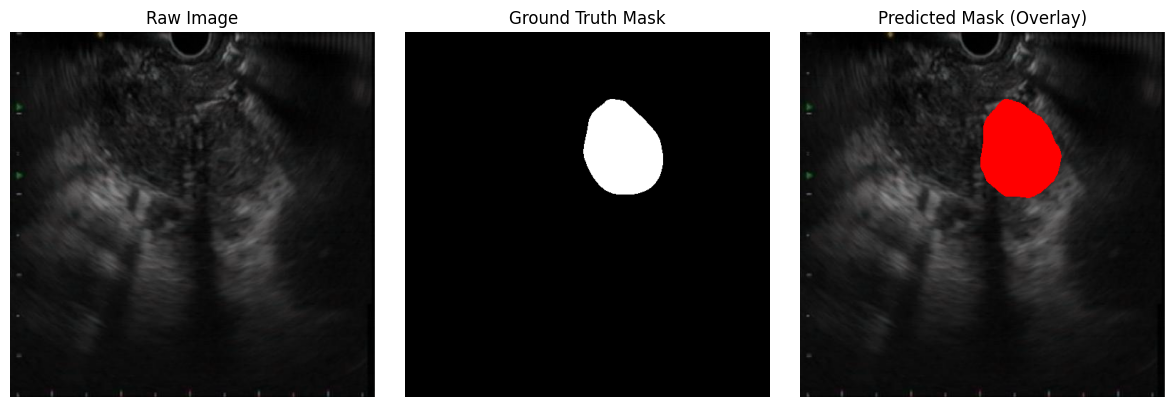

In [64]:
test_gen = TumorSegmentationGenerator(test_images, test_masks, batch_size=4)

visualize_predictions_triplet_colored(model, test_gen, num_images=50)

In [68]:
import seaborn as sns

def evaluate_and_plot(model, test_gen):
    y_trues = []
    y_preds = []

    for i in range(len(test_gen)):
        x, y = test_gen[i]

        y_true = y[0]
        if y_true.ndim == 3:
            y_true = y_true[:, :, 0]

        output = model.predict(x, verbose=0)
        y_pred = output[0]
        if y_pred.ndim == 4:
            y_pred = y_pred[0, :, :, 0]
        elif y_pred.ndim == 3:
            y_pred = y_pred[:, :, 0]

        if y_pred.shape != y_true.shape:
            y_pred = tf.image.resize(y_pred[..., np.newaxis], y_true.shape, method='bilinear').numpy().squeeze()

        y_trues.extend(y_true.flatten())
        y_preds.extend(y_pred.flatten())

    y_trues = np.array(y_trues)
    y_preds = np.array(y_preds)
    y_preds_binary = (y_preds > 0.5).astype(np.uint8)

    # Metrics
    from sklearn.metrics import (
        accuracy_score, precision_score, recall_score, f1_score,
        confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve,
        average_precision_score, jaccard_score
    )

    acc = accuracy_score(y_trues, y_preds_binary)
    prec = precision_score(y_trues, y_preds_binary, zero_division=0)
    rec = recall_score(y_trues, y_preds_binary, zero_division=0)
    f1 = f1_score(y_trues, y_preds_binary, zero_division=0)
    dice = 2 * (prec * rec) / (prec + rec + 1e-6)
    iou = jaccard_score(y_trues, y_preds_binary, zero_division=0)

    cm = confusion_matrix(y_trues, y_preds_binary)
    fpr, tpr, _ = roc_curve(y_trues, y_preds)
    auc_score = roc_auc_score(y_trues, y_preds)
    precision_vals, recall_vals, _ = precision_recall_curve(y_trues, y_preds)
    avg_prec = average_precision_score(y_trues, y_preds)

    # Plot
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    plt.subplot(1, 3, 2)
    plt.plot(fpr, tpr, color="orange", label=f"AUC = {auc_score:.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(recall_vals, precision_vals, color="green", label=f"AP = {avg_prec:.2f}")
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"Dice     : {dice:.4f}")
    print(f"IoU      : {iou:.4f}")

<ipython-input-68-95420f07706e>:75: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


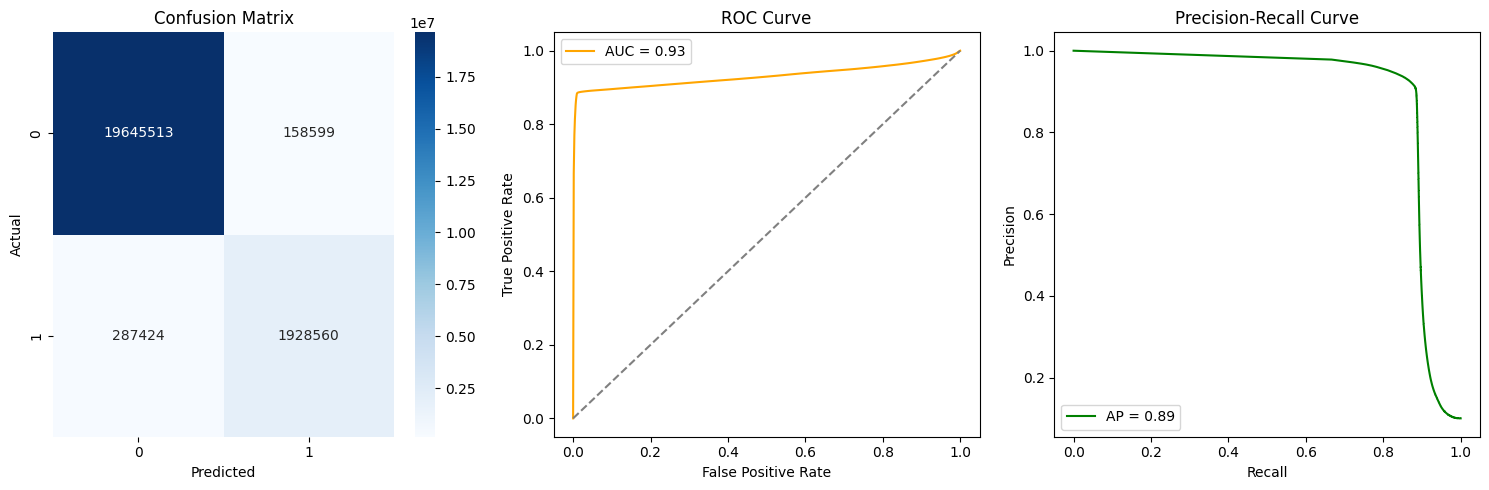

Accuracy : 0.9797
Precision: 0.9240
Recall   : 0.8703
F1 Score : 0.8963
Dice     : 0.8963
IoU      : 0.8122


In [69]:
evaluate_and_plot(model, test_gen)